In [1]:
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import re
from math import ceil


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
path = "/content/drive/MyDrive/data/*/patient*.xlsx"
all_files = glob.glob(path)

patients_2018 = [559,563,570,575,588,591]

col_names = ['year','month','day','hour','minute','second','glucose','finger_stick','basal','temp_basal','basal_final','bolus_normal','bolus_squared','total_bolus','bwz_cho','cho_original','meal_original','sleep','work','stressors','hypo_event','illness','exercice','basis_heart_rate','basis_gsr','basis_skin_temperature','basis_air_temperature','basis_step','basis_sleep','total_insulin','iob','plasma_insulin','cho','meal','cob','aob_3h','aob_6h']

dfs = []

for idx, file in enumerate(all_files):
    use_cols = []
    pattern = r"/data/(\d+)/patient"
    matched = re.search(pattern, file)
    patient_id = int(matched.group(1))
    if(patient_id in patients_2018):
      temp_df = pd.read_excel(file,dtype={},  names= col_names, header=None)
      temp_df['patient'] = patient_id
      temp_df['group'] = 'test' if 'test' in file else 'train'
      dfs.append(temp_df)


df_all = pd.concat(dfs, ignore_index=True)

# Construimos el timestamp partir de las columnas de tiempo
df_all['timestamp'] = pd.to_datetime(
    df_all['year'].astype(str) + '-' +
    df_all['month'].astype(str).str.zfill(2) + '-' +
    df_all['day'].astype(str).str.zfill(2) + ' ' +
    df_all['hour'].astype(str).str.zfill(2) + ':' +
    df_all['minute'].astype(str).str.zfill(2) + ':' +
    df_all['second'].astype(str).str.zfill(2)
)

# Añadimos la columna dia de la semana
df_all['day_of_week'] = df_all['timestamp'].dt.dayofweek

In [4]:
# Detección de duplicados
duplicates = df_all.duplicated()
duplicates.sum()

0

Reemplazamos los valores 0 por NaN en la columna glucose, y finger_stick

In [5]:
def replace_zeros(df, column_name):
    df.loc[df[column_name] == 0, column_name] = np.nan
    return df

# Reemplazamos en las columnas glucosa y finger_stick los 0's por nan
df_all = replace_zeros(df_all, 'glucose')
df_all = replace_zeros(df_all, 'finger_stick')

In [6]:
#Análisis de valores nullos
df_all.isnull( ).sum( )

year                          0
month                         0
day                           0
hour                          0
minute                        0
second                        0
glucose                    7995
finger_stick              90637
basal                         0
temp_basal                    0
basal_final                   0
bolus_normal                  0
bolus_squared                 0
total_bolus                   0
bwz_cho                       0
cho_original                  0
meal_original                 0
sleep                         0
work                          0
stressors                     0
hypo_event                    0
illness                       0
exercice                      0
basis_heart_rate              0
basis_gsr                     0
basis_skin_temperature        0
basis_air_temperature         0
basis_step                    0
basis_sleep                   0
total_insulin                 0
iob                           0
plasma_i

In [7]:
#Registros por paciente
patient_counts = df_all['patient'].value_counts()
print('Registros por paciente:')
print(patient_counts.to_string())

Registros por paciente:
588    16047
563    15989
575    15984
591    15640
559    14963
570    14597


**Visor para ver los datos por paciente y rango de fechas**

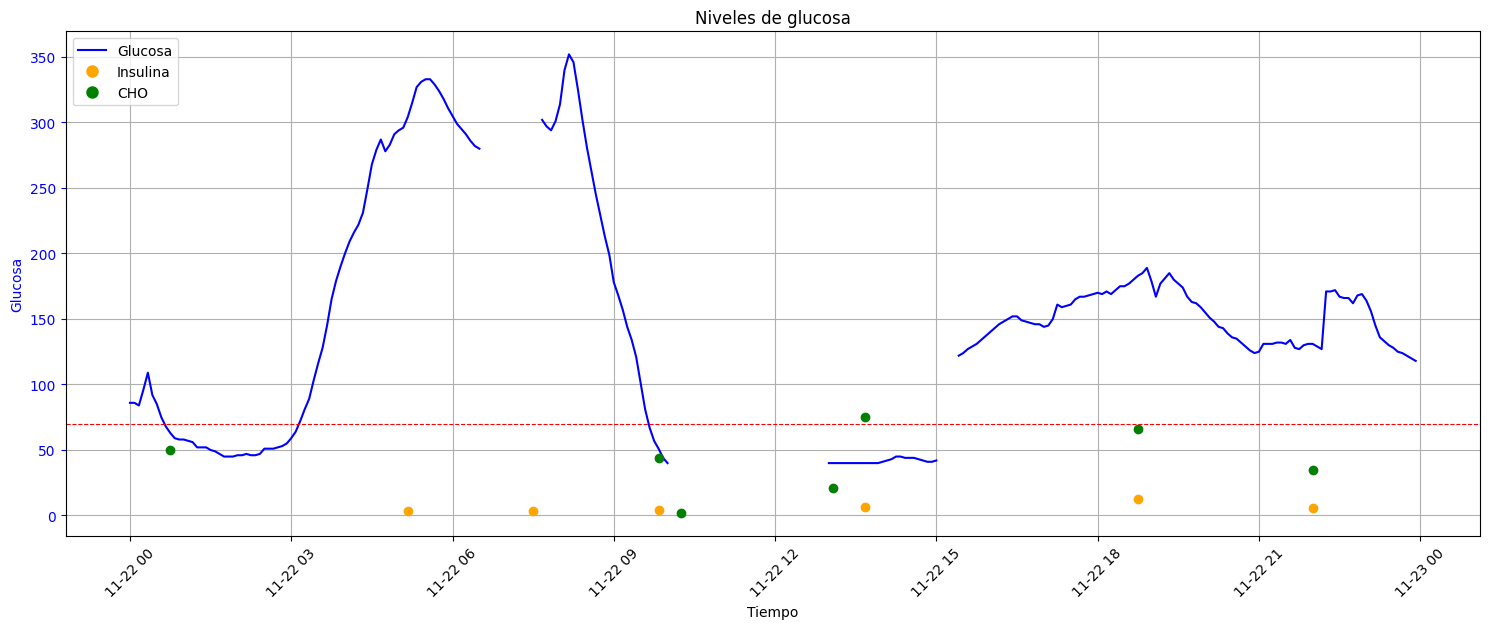

In [8]:
from matplotlib.lines import Line2D
start_date = "2021-11-22" # @param {type:"date"}
end_date = "2021-11-22" # @param {type:"date"}
patient_id = "575" # @param ["559", "563", "570", "575", "588", "591"]

interval_data = df_all.loc[(df_all['timestamp'] >= datetime.strptime(start_date,'%Y-%m-%d')) & (df_all['timestamp'].dt.date <= datetime.strptime(end_date,'%Y-%m-%d').date()) & (df_all['patient'] == int(patient_id))]

fig, ax1 = plt.subplots(figsize=(15, 6))

glucose_line, = ax1.plot(interval_data['timestamp'], interval_data['glucose'], color='b', label='Glucosa')
ax1.set_xlabel('Tiempo')
ax1.set_ylabel('Glucosa', color='b')
ax1.tick_params('y', colors='b')
ax1.set_title('Niveles de glucosa')
ax1.axhline(70, color='red', linewidth=0.8, linestyle='--')

for ts, insulin, cho in zip(interval_data['timestamp'], interval_data['total_bolus'], interval_data['cho']):
    if insulin != 0:
        ax1.plot(ts, insulin, 'o', color='orange')
    if cho != 0:
        ax1.plot(ts, cho, 'o', color='green')

legend_elements = [glucose_line,
                   Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', markersize=10, label='Insulina'),
                   Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='CHO')]

ax1.legend(handles=legend_elements, loc="upper left")

fig.tight_layout()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


Registros de comidas por paciente

In [9]:
cho_counts = df_all[df_all['cho'] != 0].groupby(['patient']).size()
cho_counts

patient
559    208
563    242
570    174
575    295
588    272
591    266
dtype: int64

Valores de glucosa por debajo de 54 (hipoglicemia nivel 2).

In [10]:
df_all[df_all['glucose'] < 54].groupby(['patient']).size()

patient
559    103
563     35
570     14
575    292
588     25
591    133
dtype: int64

Totales comidas por tipo. En las de tipo 0 (desconocido) se podría intentar reasignar el valor basándose en la hora.

In [11]:
print('Total de registros por paciente y tipo de comida:')
df_all[df_all['cho'] != 0].groupby(['patient','meal']).size()

Total de registros por paciente y tipo de comida:


patient  meal
559      0       32
         1       51
         2       44
         3       46
         4       28
         5        7
563      0       87
         1       49
         2       49
         3       46
         4        3
         5        8
570      0        7
         1       47
         2       38
         3       49
         4       32
         5        1
575      0       15
         1       49
         2       47
         3       56
         4       90
         5       38
588      0       18
         1       55
         2       57
         3       55
         4       74
         5       13
591      0       20
         1       58
         2       53
         3       51
         4       77
         5        7
dtype: int64

Obtenemos todos los registros que pertenecen a comidas, excluyendo las de tipo 5

In [12]:
def get_meals(df):
  df_meal = df[(df['cho'] != 0) & (df['meal'] != 5)]
  return df_meal

cho_meal_df = get_meals(df_all)

Añadimos la columna next_meal_postprandial_timestamp, que indica el momento en que ha habido una nueva ingesta de comida en el periodo postprandial

In [13]:
def calculate_next_meal_postprandial_timestamp(df,row):
    postprandial_period = pd.Timedelta(hours=4)
    meal_time = row['timestamp']
    patient = row['patient']
    future_meals = df[(df['timestamp'] > meal_time) & (df['timestamp'] <= meal_time + postprandial_period) & (df['patient'] == patient) & (df['cho'] != 0)]
    timestamp = future_meals['timestamp'].min()
    return timestamp

cho_meal_df['next_meal_postprandial_timestamp'] = cho_meal_df.apply(lambda row: calculate_next_meal_postprandial_timestamp(df_all, row), axis=1)

<ipython-input-13-77ea531cadb7>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cho_meal_df['next_meal_postprandial_timestamp'] = cho_meal_df.apply(lambda row: calculate_next_meal_postprandial_timestamp(df_all, row), axis=1)


Calcula la hora en que empieza una hipoglicemia postprandial caso que exista

In [14]:
def calculate_hypoglycemia_event(df,row):
    postprandial_period = pd.Timedelta(hours=4)
    meal_time = row['timestamp']
    patient = row['patient']
    future_meals = df[(df['timestamp'] > meal_time) & (df['timestamp'] <= meal_time + postprandial_period) & (df['patient'] == patient) & (df['cho'] != 0)]
    end_time = meal_time + postprandial_period
    period_df = df[(df['timestamp'] >= meal_time) & (df['timestamp'] <= end_time) & (df['patient'] == patient)]
    period_hypo = period_df[period_df['glucose'] < 70]
    period_hypo = period_hypo.sort_values('timestamp')
    count = 0
    start_time = None
    for i in range(len(period_hypo)):
        if i == 0:
            count = 1
            start_time = period_hypo.iloc[i]['timestamp']
        else:
          time_diff = (period_hypo.iloc[i]['timestamp'] - period_hypo.iloc[i-1]['timestamp']) / pd.Timedelta(minutes=1)
          if time_diff == 5:
              count += 1
          else:
              count = 1
              start_time = period_hypo.iloc[i]['timestamp']
          if count >= 3:
              return start_time
    return None

cho_meal_df['hypoglycemia_start_event'] = cho_meal_df.apply(lambda row: calculate_hypoglycemia_event(df_all, row), axis=1)

<ipython-input-14-7999b82c5cb4>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cho_meal_df['hypoglycemia_start_event'] = cho_meal_df.apply(lambda row: calculate_hypoglycemia_event(df_all, row), axis=1)


Calcula la hora en que empieza una hipoglicemia severa postprandial en caso que exista

In [15]:
def calculate_severe_hypoglycemia_event(df,row):
    postprandial_period = pd.Timedelta(hours=4)
    meal_time = row['timestamp']
    patient = row['patient']
    future_meals = df[(df['timestamp'] > meal_time) & (df['timestamp'] <= meal_time + postprandial_period) & (df['patient'] == patient) & (df['cho'] != 0)]
    end_time = meal_time + postprandial_period
    period_df = df[(df['timestamp'] >= meal_time) & (df['timestamp'] <= end_time) & (df['patient'] == patient)]
    period_hypo = period_df[period_df['glucose'] < 54]
    period_hypo = period_hypo.sort_values('timestamp')
    count = 0
    start_time = None
    for i in range(len(period_hypo)):
        if i == 0:
            count = 1
            start_time = period_hypo.iloc[i]['timestamp']
        else:
          time_diff = (period_hypo.iloc[i]['timestamp'] - period_hypo.iloc[i-1]['timestamp']) / pd.Timedelta(minutes=1)
          if time_diff == 5:
              count += 1
          else:
              count = 1
              start_time = period_hypo.iloc[i]['timestamp']
          if count >= 3:
              return start_time
    return None

cho_meal_df['severe_hypoglycemia_start_event'] = cho_meal_df.apply(lambda row: calculate_severe_hypoglycemia_event(df_all, row), axis=1)

<ipython-input-15-5c05ead30809>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cho_meal_df['severe_hypoglycemia_start_event'] = cho_meal_df.apply(lambda row: calculate_severe_hypoglycemia_event(df_all, row), axis=1)


Calcula el momento en que se da una hiperglicemia

In [17]:
def calculate_hyperglycemia_event(df,row):
    postprandial_period = pd.Timedelta(hours=4)
    meal_time = row['timestamp']
    patient = row['patient']
    future_meals = df[(df['timestamp'] > meal_time) & (df['timestamp'] <= meal_time + postprandial_period) & (df['patient'] == patient) & (df['cho'] != 0)]
    end_time = meal_time + postprandial_period
    period_df = df[(df['timestamp'] >= meal_time) & (df['timestamp'] <= end_time) & (df['patient'] == patient)]
    period_hyper = period_df[period_df['glucose'] > 180]
    period_hyper = period_hyper.sort_values('timestamp')
    count = 0
    start_time = None
    for i in range(len(period_hyper)):
        if i == 0:
            count = 1
            start_time = period_hyper.iloc[i]['timestamp']
        else:
          time_diff = (period_hyper.iloc[i]['timestamp'] - period_hyper.iloc[i-1]['timestamp']) / pd.Timedelta(minutes=1)
          if time_diff == 5:
              count += 1
          else:
              count = 1
              start_time = period_hyper.iloc[i]['timestamp']
          if count >= 3:
              return start_time
    return None

cho_meal_df['hyperglycemia_start_event'] = cho_meal_df.apply(lambda row: calculate_hyperglycemia_event(df_all, row), axis=1)

cho_meal_df['hyperglycemia'] = cho_meal_df['hyperglycemia_start_event'].apply(lambda x: 0 if pd.isnull(x) else 1)

<ipython-input-17-ad362d57b8de>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cho_meal_df['hyperglycemia_start_event'] = cho_meal_df.apply(lambda row: calculate_hyperglycemia_event(df_all, row), axis=1)
<ipython-input-17-ad362d57b8de>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cho_meal_df['hyperglycemia'] = cho_meal_df['hyperglycemia_start_event'].apply(lambda x: 0 if pd.isnull(x) else 1)


In [18]:
# # Añadimos la columna hypoglycemia, hypoglycemia_sever y hypoglycemia_multiclass
cho_meal_df['hypoglycemia'] = cho_meal_df['hypoglycemia_start_event'].apply(lambda x: 0 if pd.isnull(x) else 1)
cho_meal_df['hypoglycemia_severe'] = cho_meal_df['severe_hypoglycemia_start_event'].apply(lambda x: 0 if pd.isnull(x) else 1)
cho_meal_df['hypoglycemia_multiclass'] = cho_meal_df.apply(
    lambda row: 0 if pd.isnull(row['hypoglycemia_start_event'])
                else (2 if not pd.isnull(row['severe_hypoglycemia_start_event'])
                else 1),
    axis=1
)

<ipython-input-18-ad25675d2070>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cho_meal_df['hypoglycemia'] = cho_meal_df['hypoglycemia_start_event'].apply(lambda x: 0 if pd.isnull(x) else 1)
<ipython-input-18-ad25675d2070>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cho_meal_df['hypoglycemia_severe'] = cho_meal_df['severe_hypoglycemia_start_event'].apply(lambda x: 0 if pd.isnull(x) else 1)
<ipython-input-18-ad25675d2070>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

In [19]:
# Añade una columna que indica la insulina inyectada durante el periodo postprandial, más allá de la inyectada justo después de la ingestión,
# excluimos la total squared suministrada en el momento de la ingesta
def calculate_extra_insulin_postprandial_timestamp(row, df):
    current_time = row['timestamp']
    init_period = current_time + pd.Timedelta(minutes=35)
    end_period = current_time + pd.Timedelta(minutes=240)
    extra_insulin_postprandial_timestamp = df.loc[(df['timestamp'] > init_period) & (df['timestamp'] <= end_period) & (df['total_bolus'] != 0) & (df['patient'] == row['patient']), 'timestamp'].min()
    return extra_insulin_postprandial_timestamp

cho_meal_df['extra_insulin_postprandial_timestamp'] = cho_meal_df.apply(lambda row: calculate_extra_insulin_postprandial_timestamp(row,df_all), axis = 1)


<ipython-input-19-8dcc4750acc3>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cho_meal_df['extra_insulin_postprandial_timestamp'] = cho_meal_df.apply(lambda row: calculate_extra_insulin_postprandial_timestamp(row,df_all), axis = 1)


In [20]:
#Consideramos inválidos, las comidas en que existe una comida antes de las 4 horas o una dosis extra de insulina, siempre que no haya ocurrida una hipoglucemia previamente
def calculate_valid_hypoglycemia_meal(row):
    # print(row.name)
    valid = False
    hypoglycemia_start_event = row['hypoglycemia_start_event']
    next_meal_postprandial_timestamp = row['next_meal_postprandial_timestamp']
    extra_insulin_postprandial_timestamp = row['extra_insulin_postprandial_timestamp']
    #Si no hay hipoglucemia, y hay una comida extra en el periodo postprandial, no es valido
    #Si hay hipoglucemia, y hay una comida extra o una dosi extra de insulina antes del momento de la hipoglucemia, no es valido
    exists_next_meal_postprandial = pd.notnull(next_meal_postprandial_timestamp)
    exists_insulin_postprandial = pd.notnull(extra_insulin_postprandial_timestamp)
    not_exists_next_meal_postprandial_before_hypoglycemia = (not exists_next_meal_postprandial) | ((exists_next_meal_postprandial) & (pd.notnull(hypoglycemia_start_event)) & (hypoglycemia_start_event >= next_meal_postprandial_timestamp))
    not_exists_insulin_postprandial_before_hypoglycemia = (not exists_insulin_postprandial) | ((exists_insulin_postprandial) & (pd.notnull(hypoglycemia_start_event)) & (hypoglycemia_start_event >= extra_insulin_postprandial_timestamp))
    if(((not exists_next_meal_postprandial) | (not not_exists_next_meal_postprandial_before_hypoglycemia)) & ((not exists_insulin_postprandial) & (not_exists_insulin_postprandial_before_hypoglycemia))):
      valid = True
    return valid

cho_meal_df['valid_hypoglycemia'] = cho_meal_df.apply(lambda row: calculate_valid_hypoglycemia_meal(row), axis = 1)


<ipython-input-20-31e0a03eeeb9>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cho_meal_df['valid_hypoglycemia'] = cho_meal_df.apply(lambda row: calculate_valid_hypoglycemia_meal(row), axis = 1)


In [21]:
cho_meal_df[cho_meal_df['valid_hypoglycemia']].groupby(['hypoglycemia_multiclass']).size()

hypoglycemia_multiclass
0    621
1     83
2     33
dtype: int64

In [22]:
#Consideramos inválidos, las comidas en que existe una comida antes de las 4 horas o una dosis extra de insulina, siempre que no haya ocurrido una hiperglucemia previamente
def calculate_valid_hyperglycemia_meal(row):
    valid = False
    hyperglycemia_start_event = row['hyperglycemia_start_event']
    next_meal_postprandial_timestamp = row['next_meal_postprandial_timestamp']
    extra_insulin_postprandial_timestamp = row['extra_insulin_postprandial_timestamp']
    #Si no hay hipoglucemia, y hay una comida extra en el periodo postprandial, no es valido
    #Si hay hipoglucemia, y hay una comida extra o una dosi extra de insulina antes del momento de la hipoglucemia, no es valido
    exists_next_meal_postprandial = pd.notnull(next_meal_postprandial_timestamp)
    exists_insulin_postprandial = pd.notnull(extra_insulin_postprandial_timestamp)
    not_exists_next_meal_postprandial_before_hyperglycemia = (not exists_next_meal_postprandial) | ((exists_next_meal_postprandial) & (pd.notnull(hyperglycemia_start_event)) & (hyperglycemia_start_event >= next_meal_postprandial_timestamp))
    not_exists_insulin_postprandial_before_hyperglycemia = (not exists_insulin_postprandial) | ((exists_insulin_postprandial) & (pd.notnull(hyperglycemia_start_event)) & (hyperglycemia_start_event >= extra_insulin_postprandial_timestamp))
    if((hyperglycemia_start_event != row['timestamp']) & ((not exists_next_meal_postprandial) | (not not_exists_next_meal_postprandial_before_hyperglycemia)) & ((not exists_insulin_postprandial) & (not_exists_insulin_postprandial_before_hyperglycemia))):
      valid = True
    return valid

cho_meal_df['valid_hyperglycemia'] = cho_meal_df.apply(lambda row: calculate_valid_hyperglycemia_meal(row), axis = 1)

<ipython-input-22-9656298cdc1b>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cho_meal_df['valid_hyperglycemia'] = cho_meal_df.apply(lambda row: calculate_valid_hyperglycemia_meal(row), axis = 1)


Comprovamos en que hora ocurren las hipoglucemias.

In [23]:
def calculate_hypoglycemia_start_hour(row):
    if pd.isnull(row['hypoglycemia_start_event']):
        return np.nan
    else:
        time_diff = row['hypoglycemia_start_event'] - row['timestamp']
        return ceil((row['hypoglycemia_start_event'] - row['timestamp']).seconds / 3600)

cho_meal_df['hypoglycemia_start_hour'] = cho_meal_df.apply(calculate_hypoglycemia_start_hour, axis=1)
print(cho_meal_df[(cho_meal_df['hypoglycemia'] != 0) & (pd.notna(cho_meal_df['hypoglycemia']))].groupby('hypoglycemia_start_hour').size())

hypoglycemia_start_hour
0.0    49
1.0    34
2.0    43
3.0    55
4.0    36
dtype: int64


<ipython-input-23-81bc44c83f2a>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cho_meal_df['hypoglycemia_start_hour'] = cho_meal_df.apply(calculate_hypoglycemia_start_hour, axis=1)


In [24]:
total_ingestas_cho = len(cho_meal_df)
total_ingestas_cho_sin_nueva_ingesta_4h = len(cho_meal_df[cho_meal_df['valid_hypoglycemia']]) #válidas
total_ingestas_validas_sin_hypo = len(cho_meal_df[(cho_meal_df['hypoglycemia'] == 0) & (cho_meal_df['valid_hypoglycemia'])])
total_ingestas_validas_con_hypo = len(cho_meal_df[(cho_meal_df['hypoglycemia'] == 1) & (cho_meal_df['valid_hypoglycemia'])])
total_ingestas_validas_con_hypo_test = len(cho_meal_df[(cho_meal_df['hypoglycemia'] == 1) & (cho_meal_df['valid_hypoglycemia']) & (cho_meal_df['group'] == 'test')])
total_ingestas_validas_con_hypo_severa = len(cho_meal_df[(cho_meal_df['hypoglycemia_severe'] == 1) & (cho_meal_df['valid_hypoglycemia'])])
total_ingestas_validas_con_hypo_severa_test = len(cho_meal_df[(cho_meal_df['hypoglycemia_severe'] == 1) & (cho_meal_df['valid_hypoglycemia']) & (cho_meal_df['group'] == 'test')])
print("Total ingestas CHO: " + str(total_ingestas_cho))
print("Total ingestas CHO sin ingesta en 4h: " + str(total_ingestas_cho_sin_nueva_ingesta_4h))
print("Total ingestas CHO válidas sin hypo: " + str(total_ingestas_validas_sin_hypo))
print("Total ingestas CHO válidas con hypo: " + str(total_ingestas_validas_con_hypo))
print("Total ingestas CHO válidas con hypo test: " + str(total_ingestas_validas_con_hypo_test))
print("Total ingestas CHO válidas con hypo severa: " + str(total_ingestas_validas_con_hypo_severa))
print("Total ingestas CHO válidas con hypo severa test: " + str(total_ingestas_validas_con_hypo_severa_test))


Total ingestas CHO: 1383
Total ingestas CHO sin ingesta en 4h: 737
Total ingestas CHO válidas sin hypo: 621
Total ingestas CHO válidas con hypo: 116
Total ingestas CHO válidas con hypo test: 14
Total ingestas CHO válidas con hypo severa: 33
Total ingestas CHO válidas con hypo severa test: 6


Registros válidos por paciente y hipoglicemia

In [25]:
print(cho_meal_df[(pd.notna(cho_meal_df['hypoglycemia'])) & (cho_meal_df['valid_hypoglycemia'])].groupby(['patient','hypoglycemia']).size())

patient  hypoglycemia
559      0               114
         1                20
563      0                58
         1                10
570      0                85
         1                 9
575      0               119
         1                46
588      0               152
         1                 9
591      0                93
         1                22
dtype: int64


Añadimos características de los valores de glucosa a 30 minutos y 1 hora.

In [26]:
def calculate_previous_minutes_glucose(row, df, minutes_before):
    current_time = row['timestamp']
    time_minutes_before = current_time - pd.Timedelta(minutes=minutes_before)
    glucose_minutes_before = df.loc[(df['timestamp'] == time_minutes_before) & (df['patient'] == row['patient']), 'glucose']
    if not glucose_minutes_before.empty:
        glucose_minutes_before = glucose_minutes_before.values[0]
    else:
        glucose_minutes_before = np.nan
    return glucose_minutes_before

minutes_1h_before = 60
cho_meal_df['glucose_1h'] = cho_meal_df.apply(lambda row: calculate_previous_minutes_glucose(row, df_all, minutes_1h_before), axis=1)

minutes_30_before = 30
cho_meal_df['glucose_30m'] = cho_meal_df.apply(lambda row: calculate_previous_minutes_glucose(row, df_all, minutes_30_before), axis=1)


<ipython-input-26-6c69bac45ad5>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cho_meal_df['glucose_1h'] = cho_meal_df.apply(lambda row: calculate_previous_minutes_glucose(row, df_all, minutes_1h_before), axis=1)
<ipython-input-26-6c69bac45ad5>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cho_meal_df['glucose_30m'] = cho_meal_df.apply(lambda row: calculate_previous_minutes_glucose(row, df_all, minutes_30_before), axis=1)


Calculamos la media de la glucosa en la última hora

In [27]:
def calculate_previous_minutes_mean_glucose(row, df, minutes_before):
    current_time = row['timestamp']
    time_minutes_before = current_time - pd.Timedelta(minutes=minutes_before)
    glucose_minutes_before = df.loc[(df['timestamp'] >= time_minutes_before) & (df['timestamp'] < current_time) & (df['patient'] == row['patient']), 'glucose']
    if not glucose_minutes_before.empty:
        mean_glucose_minutes_before = glucose_minutes_before.mean()
    else:
        mean_glucose_minutes_before = np.nan
    return mean_glucose_minutes_before

cho_meal_df['mean_glucose_1h'] = cho_meal_df.apply(lambda row: calculate_previous_minutes_mean_glucose(row, df_all, 60), axis=1)

<ipython-input-27-7747bbfeba4d>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cho_meal_df['mean_glucose_1h'] = cho_meal_df.apply(lambda row: calculate_previous_minutes_mean_glucose(row, df_all, 60), axis=1)


Calculamos el rango de la glucosa en una hora

In [28]:
def calculate_glucose_range(row, df):
    current_time = row['timestamp']
    current_glucose = row['glucose']
    time_minutes_before = current_time - pd.Timedelta(minutes=60)
    glucose_minutes_before = df.loc[(df['timestamp'] == time_minutes_before) & (df['patient'] == row['patient']), 'glucose']
    if not glucose_minutes_before.empty:
        glucose_range = abs(glucose_minutes_before.values[0] - current_glucose)
    else:
        glucose_range = np.nan
    return glucose_range

cho_meal_df['glucose_range'] = cho_meal_df.apply(lambda row: calculate_glucose_range(row, df_all), axis=1)

<ipython-input-28-aed689136734>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cho_meal_df['glucose_range'] = cho_meal_df.apply(lambda row: calculate_glucose_range(row, df_all), axis=1)


Calculamos la tasa de ratio de la glucosa

In [30]:
def calculate_glucose_rate_change(row, df, minutes_before):
    current_time = row['timestamp']
    current_glucose = row['glucose']
    time_minutes_before = current_time - pd.Timedelta(minutes=minutes_before)
    glucose_minutes_before = df.loc[(df['timestamp'] == time_minutes_before) & (df['patient'] == row['patient']), 'glucose']
    if not glucose_minutes_before.empty:
        glucose_range = (glucose_minutes_before.values[0] - current_glucose) / minutes_before
    else:
        glucose_range = np.nan
    return glucose_range

cho_meal_df['glucose_rate_change'] = cho_meal_df.apply(lambda row: calculate_glucose_rate_change(row, df_all, 60), axis=1)

<ipython-input-30-3675f15829c4>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cho_meal_df['glucose_rate_change'] = cho_meal_df.apply(lambda row: calculate_glucose_rate_change(row, df_all, 60), axis=1)


Cálculo de la columna next_iob, ya que la administración de insulina suele coincidir con la ingesta de comida, y el iob se actualiza en el siguiente registro (5 minutos)

In [31]:
def calculate_next_iob(row, df):
    current_time = row['timestamp']
    next_time = current_time + pd.Timedelta(minutes=5)
    next_iob = df.loc[(df['timestamp'] == next_time) & (df['patient'] == row['patient']), 'iob']
    if not next_iob.empty:
        next_iob = next_iob.values[0]
    else:
        next_iob = np.nan
    return next_iob

cho_meal_df['next_iob'] = cho_meal_df.apply(lambda row: calculate_next_iob(row,df_all), axis = 1)

<ipython-input-31-5da8790f1657>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cho_meal_df['next_iob'] = cho_meal_df.apply(lambda row: calculate_next_iob(row,df_all), axis = 1)


Cálculo de la nueva columna total_bolus_squared, que nos indica el total administrado de bolus squared en un periodo de 35 minutos posterior a la ingesta.

In [32]:
def calculate_total_bolus_squared(row, df):
    current_time = row['timestamp']
    bolus_squared_period = current_time + pd.Timedelta(minutes=35)
    next_iob = df.loc[(df['timestamp'] > current_time) & (df['timestamp'] <= bolus_squared_period) & (df['patient'] == row['patient']), 'bolus_squared']
    if not next_iob.empty:
        total_bolus_squared = sum(next_iob.values)
    else:
        total_bolus_squared = 0
    return total_bolus_squared

cho_meal_df['total_bolus_squared'] = cho_meal_df.apply(lambda row: calculate_total_bolus_squared(row,df_all), axis = 1)

<ipython-input-32-03cce6c2f048>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cho_meal_df['total_bolus_squared'] = cho_meal_df.apply(lambda row: calculate_total_bolus_squared(row,df_all), axis = 1)


Substituimos los valores de glucose por los de finger_stick, cuando no estén disponibles los de la glucosa GCM

In [33]:
cho_meal_df['glucose'] = cho_meal_df['glucose'].combine_first(cho_meal_df['finger_stick'])

<ipython-input-33-4c4860f08d42>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cho_meal_df['glucose'] = cho_meal_df['glucose'].combine_first(cho_meal_df['finger_stick'])


In [36]:
#Análisis de valores nullos
cho_meal_df[cho_meal_df['valid_hypoglycemia'] == 1].isnull( ).sum().to_frame()

,0
year,0
month,0
day,0
hour,0
minute,0
second,0
glucose,14
finger_stick,184
basal,0
temp_basal,0


Guardar archivo para entrenar los modelos de hipoglicemia

In [37]:
df_hypoglycemia_complete = cho_meal_df[cho_meal_df['valid_hypoglycemia']][['cho','meal','basal','total_bolus','bolus_normal','total_bolus_squared','glucose', 'glucose_range','glucose_rate_change','mean_glucose_1h' ,'glucose_1h','glucose_30m','iob', 'next_iob','cob','aob_3h','aob_6h','hour','day_of_week','hypoglycemia','hypoglycemia_severe','hypoglycemia_multiclass','group']]
df_hypoglycemia_complete.to_csv('postprandial_hypoglycemias.csv', index=False)